In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"roshanupadhyay07","key":"24064c54065446c889ac2c912e483f8c"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d dheerajperumandla/drowsiness-dataset

 99% 160M/161M [00:08<00:00, 23.0MB/s]
100% 161M/161M [00:08<00:00, 20.3MB/s]


In [5]:
!unzip drowsiness-dataset.zip

Archive:  drowsiness-dataset.zip
  inflating: train/Closed/_0.jpg     
  inflating: train/Closed/_1.jpg     
  inflating: train/Closed/_10.jpg    
  inflating: train/Closed/_100.jpg   
  inflating: train/Closed/_101.jpg   
  inflating: train/Closed/_102.jpg   
  inflating: train/Closed/_103.jpg   
  inflating: train/Closed/_104.jpg   
  inflating: train/Closed/_105.jpg   
  inflating: train/Closed/_106.jpg   
  inflating: train/Closed/_107.jpg   
  inflating: train/Closed/_108.jpg   
  inflating: train/Closed/_109.jpg   
  inflating: train/Closed/_11.jpg    
  inflating: train/Closed/_110.jpg   
  inflating: train/Closed/_111.jpg   
  inflating: train/Closed/_112.jpg   
  inflating: train/Closed/_113.jpg   
  inflating: train/Closed/_114.jpg   
  inflating: train/Closed/_115.jpg   
  inflating: train/Closed/_116.jpg   
  inflating: train/Closed/_117.jpg   
  inflating: train/Closed/_118.jpg   
  inflating: train/Closed/_119.jpg   
  inflating: train/Closed/_12.jpg    
  inflating: trai

In [11]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.metrics import classification_report

In [7]:
labels = os.listdir('/content/train')

In [8]:
labels

['no_yawn', 'Closed', 'yawn', 'Open']

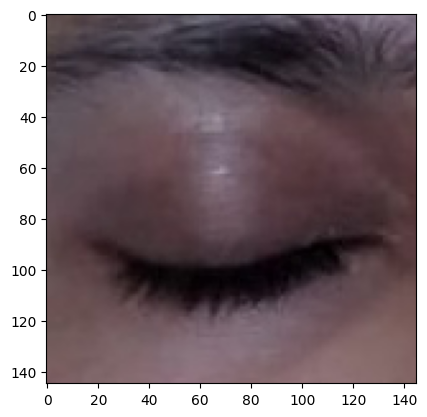

In [10]:
plt.imshow(plt.imread('/content/train/Closed/_0.jpg'))

In [14]:
def face_for_yawn(direc="/content/train", face_cas_path="/content/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


In [15]:
def get_data(dir_path="/content/train/", face_cas="/content/haarcascade_frontalface_default.xml", eye_cas="/content/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [16]:
data_train = get_data()

2
3


In [17]:
def append_data():
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

In [18]:
new_data = append_data()

0
1
2
3


<ipython-input-17-3101b219d5dc>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yaw_no)


In [19]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

In [20]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [21]:
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [22]:
y = np.array(y)

In [23]:
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [24]:
len(X_test)

578

In [26]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [27]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [28]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
43/43 [==============================] - 23s 205ms/step - loss: 1.1818 - accuracy: 0.4618 - val_loss: 0.5110 - val_accuracy: 0.7820
Epoch 2/50
43/43 [==============================] - 7s 165ms/step - loss: 0.5378 - accuracy: 0.7788 - val_loss: 0.4110 - val_accuracy: 0.8356
Epoch 3/50
43/43 [==============================] - 8s 185ms/step - loss: 0.3937 - accuracy: 0.8426 - val_loss: 0.2982 - val_accuracy: 0.8945
Epoch 4/50
43/43 [==============================] - 7s 171ms/step - loss: 0.3669 - accuracy: 0.8448 - val_loss: 0.2566 - val_accuracy: 0.8945
Epoch 5/50
43/43 [==============================] - 7s 165ms/step - loss: 0.3252 - accuracy: 0.8641 - val_loss: 0.2113 - val_accuracy: 0.9187
Epoch 6/50
43/43 [==============================] - 8s 186ms/step - loss: 0.2958 - accuracy: 0.8701 - val_loss: 0.2033 - val_accuracy: 0.9239
Epoch 7/50
43/43 [==============================] - 8s 184ms/step - loss: 0.2554 - accuracy: 0.8834 - val_loss: 0.1780 - val_accuracy: 0.9343
Epoch

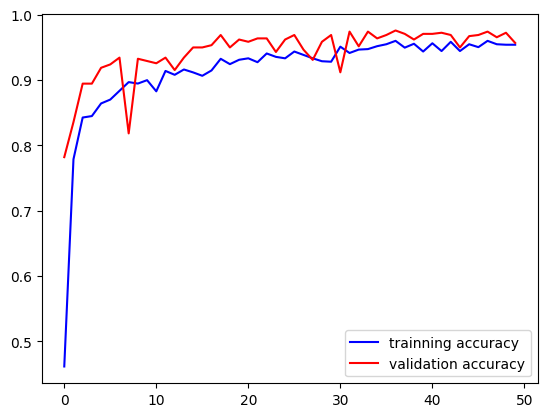

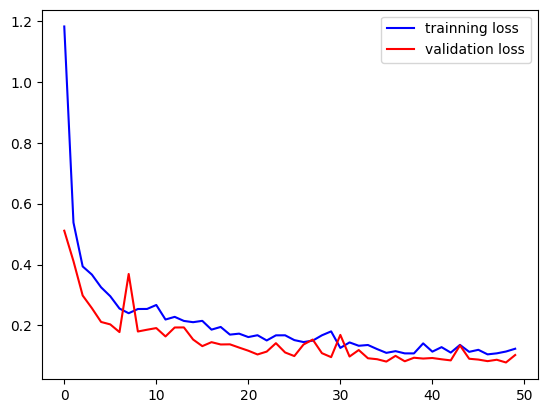

In [29]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [30]:
model.save("Driver_Drowsiness.h5")

In [32]:
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

19/19 [==============================] - 1s 25ms/step


In [34]:
classes_x

array([3, 3, 2, 3, 1, 3, 3, 2, 0, 2, 3, 3, 3, 2, 2, 2, 3, 0, 0, 3, 3, 3,
       2, 1, 1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 3, 3, 2, 1, 3, 3, 3, 2, 3,
       2, 2, 3, 3, 2, 3, 3, 1, 2, 1, 3, 3, 2, 2, 2, 0, 3, 3, 1, 3, 2, 3,
       2, 3, 2, 2, 1, 3, 3, 3, 2, 0, 0, 3, 1, 3, 2, 0, 3, 2, 2, 2, 2, 0,
       3, 3, 2, 3, 3, 3, 1, 0, 3, 0, 3, 3, 3, 1, 3, 1, 2, 3, 2, 1, 2, 2,
       1, 1, 2, 1, 0, 3, 3, 3, 2, 2, 3, 3, 3, 1, 1, 2, 3, 3, 2, 0, 3, 3,
       1, 3, 1, 2, 3, 3, 2, 1, 2, 2, 2, 1, 3, 3, 3, 3, 2, 0, 3, 3, 3, 3,
       3, 0, 0, 0, 3, 1, 3, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 1, 2, 0, 3, 3,
       2, 2, 0, 2, 3, 0, 2, 1, 3, 2, 3, 1, 2, 0, 1, 3, 2, 2, 3, 3, 3, 0,
       3, 2, 3, 0, 2, 0, 0, 1, 2, 3, 2, 0, 3, 1, 2, 2, 2, 2, 1, 3, 1, 1,
       1, 0, 2, 3, 3, 3, 3, 0, 0, 2, 0, 0, 3, 3, 1, 3, 3, 0, 2, 3, 1, 1,
       0, 1, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 0, 2, 2, 2, 0, 3, 3, 2, 2,
       3, 2, 2, 1, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 0, 1, 0, 3, 3, 3, 3, 2,
       2, 0, 2, 2, 3, 3, 2, 0, 2, 2, 1, 3, 2, 3, 1,

In [35]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [37]:
print(classification_report(np.argmax(y_test, axis=1), classes_x, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.87      0.84      0.85        63
     no_yawn       0.87      0.89      0.88        74
      Closed       0.99      0.98      0.99       215
        Open       0.98      0.99      0.99       226

    accuracy                           0.96       578
   macro avg       0.93      0.93      0.93       578
weighted avg       0.96      0.96      0.96       578



In [3]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="/content/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("Driver_Drowsiness.h5")

1/1 [==============================] - 0s 28ms/step
Closed


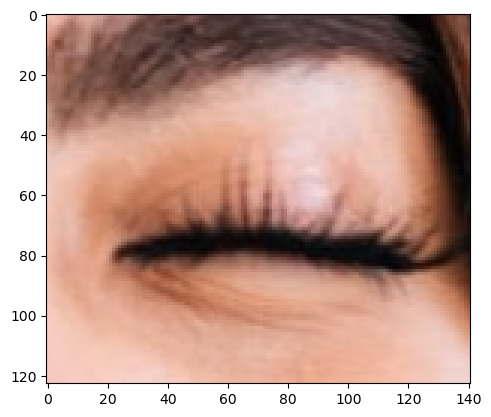

In [14]:
prediction = model.predict([prepare("./train/Closed/_101.jpg")])
print(labels_new[np.argmax(prediction)])
plt.imshow(plt.imread("./train/Closed/_101.jpg"))

1/1 [==============================] - 0s 32ms/step
Open


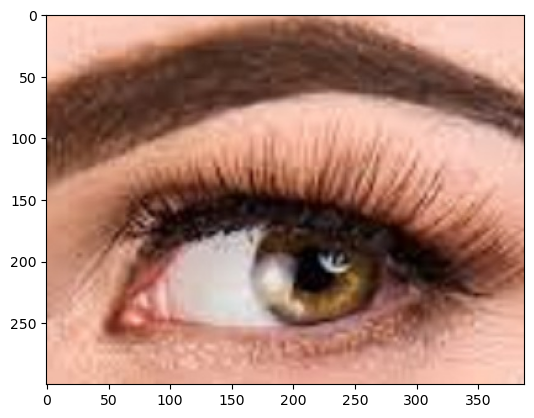

In [15]:
prediction = model.predict([prepare("./train/Open/_104.jpg")])
print(labels_new[np.argmax(prediction)])
plt.imshow(plt.imread("./train/Open/_104.jpg"))